In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
import pyvista as pv
from IPython.display import Image
from polpo.models import SupervisedEmbeddingRegressor
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.load.pregnancy import (
    NeuroMaternalMeshLoader,
    NeuroMaternalTabularDataLoader,
)
from polpo.preprocessing.mesh.conversion import (
    DataFromPv,
    PvFromData,
    ToVertices,
)
from polpo.preprocessing.mesh.io import FreeSurferReader
from polpo.preprocessing.mesh.registration import PvAlign
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
DEBUG = False

struct = "L_Hipp"

OUTPUTS_DIR = Path(".")

EDS.

In [3]:
pipe = NeuroMaternalTabularDataLoader(
    keep_mothers=True,
    keep_control=False,
)

tab_data = pipe()

In [4]:
eds_pipe = (
    ppd.DfFilter(lambda df: df["ses"] == 1)
    + ppd.IndexSetter("participant_id", drop=True)
    + ppd.ColumnsSelector("EDS.Total")
    + ppd.SeriesToDict()
)

eds_dict = eds_pipe(tab_data)

eds_dict;

Meshes.

In [5]:
as_dict = False
file_finder = NeuroMaternalMeshLoader(
    as_dict=as_dict,
    struct=struct.split("_")[-1],
    left=struct.split("_")[0] == "L",
    derivative="enigma",
)

Map_ = ppdict.DictMap if as_dict else Map


mesh_reader = ppdict.DictMap(Map_(FreeSurferReader() + PvFromData()))

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: ppdict.DictMap(Map_(PvAlign(**kwargs))),
    # NB: aligns against first subject, t_0
    _target=lambda meshes: meshes[list(meshes.keys())[0]][0],
    max_iterations=500,
)


if DEBUG:
    # because alignment is a bit slow
    pipe = file_finder + mesh_reader
else:
    pipe = file_finder + mesh_reader + prep_pipe


meshes_dict = pipe()

len(meshes_dict)

151

In [6]:
meshes2flat_vfields = ppdict.DictMap(
    step=Map(ToVertices()) + (lambda verts: (verts[1] - verts[0]).flatten())
)

flat_vfields_dict = meshes2flat_vfields(meshes_dict)

len(flat_vfields_dict)

151

In [7]:
model = SupervisedEmbeddingRegressor(
    PLSRegression(n_components=1),
    LinearRegression(),
)


model

SupervisedEmbeddingRegressor(encoder=PLSRegression(n_components=1),
                             regressor=LinearRegression())

In [8]:
dataset_pipe = (
    ppdict.DictMerger()
    + NestingSwapper()
    + IndexMap(index=0, step=lambda x: np.stack(x))
    + IndexMap(index=1, step=lambda x: np.stack(x)[:, None])
)


flat_vfields, eds = dataset_pipe((flat_vfields_dict, eds_dict))

flat_vfields.shape, eds.shape

((117, 7506), (117, 1))

In [9]:
X, y = eds, flat_vfields

model.fit(X, y)

SupervisedEmbeddingRegressor(encoder=PLSRegression(n_components=1),
                             regressor=LinearRegression())

In [10]:
z = model.encoder_.transform(y)

zmin, zmax = np.min(z), np.max(z)
Z = np.linspace(zmin, zmax, 10)[:, None]

pred_vec = model.encoder_.inverse_transform(Z).reshape(Z.shape[0], -1, 3)

In [11]:
template_mesh = meshes_dict[list(meshes_dict.keys())[0]][0]
template_vertices, template_faces = DataFromPv()(template_mesh)


pred_vertices = pred_vec + template_vertices

pred_vertices.shape

(10, 2502, 3)

In [12]:
pred_meshes = [
    PvFromData()((pred_vertices_, template_faces)) for pred_vertices_ in pred_vertices
]

In [13]:
from matplotlib.colors import TwoSlopeNorm

# TODO: update mesh colorizer to handle this


def computed_velocity_norm(ref_mesh, vec_fields, signed=True):
    vel = vec_fields
    vel_norm = np.linalg.norm(vel, axis=-1)

    if not signed:
        return vel_norm

    signed_vel_norm = []
    vertex_normals = template_mesh.point_normals
    for vel_, vel_norm_ in zip(vel, vel_norm):
        signed_vel_norm.append(
            np.sign(np.vecdot(vertex_normals, vel_, axis=-1)) * vel_norm_
        )

    return np.stack(signed_vel_norm)


def _magnitude2color(value, color_norm_, scaling_factor=1.0, cmap="coolwarm"):
    cmap = plt.get_cmap(cmap)
    return cmap(color_norm_(value * scaling_factor), bytes=True)


vel_norms = computed_velocity_norm(template_mesh, pred_vec, signed=False)
vmax = np.amax(vel_norms)

color_norm_ = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

signed_vel_norms = computed_velocity_norm(template_mesh, pred_vec, signed=True)

for mesh, vel_norm in zip(pred_meshes, signed_vel_norms):
    colors = _magnitude2color(vel_norm, color_norm_)
    mesh["colors"] = colors

In [14]:
pred_vec.shape

(10, 2502, 3)

In [15]:
pred_meshes[0]

PolyData (0x70d453426140)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.291e+02, 1.545e+02
  Y Bounds:   1.253e+02, 1.515e+02
  Z Bounds:   9.853e+01, 1.431e+02
  N Arrays:   1

In [16]:
gif_name = OUTPUTS_DIR / "regression.gif"

pl = pv.Plotter(notebook=False, off_screen=True)

pl.open_gif(gif_name.as_posix())

pl.add_mesh(pred_meshes[0], show_edges=True, rgb=True, scalars="colors")

pl.remove_legend()
pl.remove_bounds_axes()

pl.write_frame()

for mesh in pred_meshes[1:]:
    pl.update_coordinates(mesh.points, render=False)
    pl.write_frame()

pl.close()

/home/luisfpereira/miniconda3/envs/py12/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(


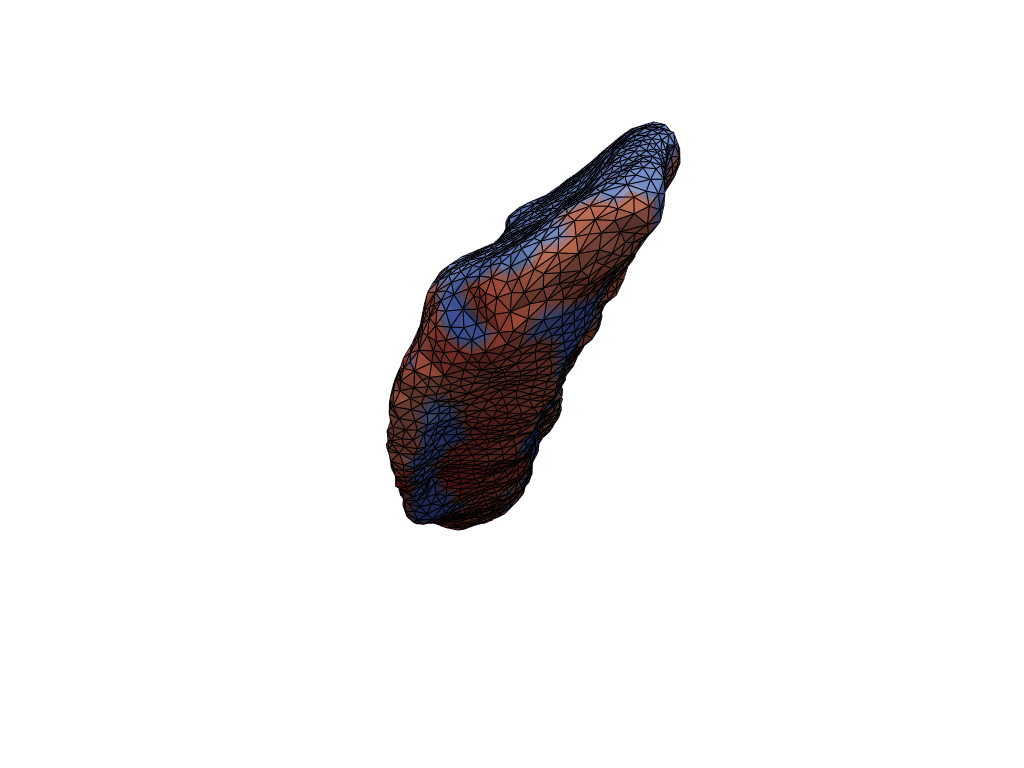

In [17]:
Image(open(gif_name, "rb").read())